# Searching for ArcticDEM and REMA strips

> This notebook is [available on GitHub here.](https://github.com/trchudley/pdemtools/blob/main/notebooks/strip_search.ipynb)

Here, we describe how we can use `pdemtools` to search for, and download, ArcticDEM and REMA strips. 

First, we must import `pdemtools`, in addition to the in-built `os` function for file management and `matplotlib` to plot our results in this notebook.

In [1]:
import os

import pdemtools as pdt
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

%matplotlib inline

## Searching for strips

For the example here, let's examine recent surface elevation change across KIV Steenstrups Nordre Bræ (where we know [significant change occurred between 2016 and 2021](https://doi.org/10.1038/s41467-023-37764-7)).


We can query all available ArcticDEM or REMA by using the `pdt.search()` function. By default, the search function automatically connects to the [PGC STAC API](https://stac.pgc.umn.edu/api/v1/), and the function essentially wraps a `pystac_client` query with a few additional bells and whistles, such as being able to query by the fractional coverage of your AOI. If you don't know what STAC or `pystac_client` is, that's fine - this tool is designed to help you engage with ArcticDEM/REMA data without getting into the weeds!

If for whatever reason, you would rather query a local source (e.g. you anticipate not having access to the internet), you can instead provide the local PGC index file location to the optional `index_fpath` parameter. For more information on this, see the 'Supplementary datasets' page.

To use the `pdt.search()` function, set an appropriate bounding box (`[xmin, ymin, xmax, ymax]`in EPSG:3413 / Polar Stereographic North*), and set further filtering choices to limit our options to high-quality, summer scenes that cover at least 70% of the bounding box.

> ⚠️
> **NOTE:** pDEMtools currently only accepts bounds in the same format as the ArcticDEM/REMA datasets themselves: that is say, the Polar Stereographic projections (EPSG:3413 for the north/ArcticDEM and EPSG:3031 for the south/REMA).


In [2]:
bounds = (459000, -2539000, 473000, -2528000)

gdf = pdt.search(
    dataset='arcticdem',
    bounds = bounds, 
    dates = '20170101/20221231',
    months = [6,7,8,9],
    years = [2017,2021],
    baseline_max_hours = 24,
    sensors=['WV03', 'WV02', 'WV01'],
    accuracy=2,
    min_aoi_frac = 0.7,
)

print(f'{len(gdf)} strips found')

6 strips found


> ⚠️
> **NOTE:** Including both `dates` and `years` as parameters in this use case is strictly redundant (because e.g. `dates = '20190101/20191231'` is functionally identical to `years = 2019`). However, it is worth highlighting that both options are avaiable to you!

The `pdt.search()` function returns a `geopandas` geodataframe, which we can visualise as with any other dataframe. There are many columns containing a variety of different data. These columns will differ depending on whether you sourced the data from the online STAC (default) or a local index file - as result, `pdemtools` appends the most useful data as columns beginning with `pdt_*`: `['pdt_id', 'pdt_datetime1', 'pdt_datetime2', 'pdt_dem_baseline_hours', 'pdt_datetime_mean', 'pdt_year', 'pdt_month', 'pdt_aoi_frac']`. Here, let's take a look at the strip IDs and the acquisition dates of the two WorldView scenes that went into making the DEM:

In [3]:
gdf[['pdt_id', 'pdt_datetime1', 'pdt_datetime2']]

,pdt_id,pdt_datetime1,pdt_datetime2
0,SETSM_s2s041_WV01_20170607_1020010063D4CE00_10...,2017-06-07 16:36:42+00:00,2017-06-07 16:37:31+00:00
1,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,2017-06-24 16:35:53+00:00,2017-06-24 16:36:43+00:00
2,SETSM_s2s041_WV03_20170728_104001002E870C00_10...,2017-07-28 14:05:24+00:00,2017-07-28 14:06:24+00:00
3,SETSM_s2s041_WV02_20170829_103001006F1D6400_10...,2017-08-29 14:21:43+00:00,2017-08-29 14:23:03+00:00
4,SETSM_s2s041_WV03_20210715_104001006A09A000_10...,2021-07-15 13:55:42+00:00,2021-07-15 13:56:37+00:00
5,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,2021-07-31 14:09:25+00:00,2021-07-31 14:10:48+00:00


There's still no guarantee that these scenes will be of high quality - so we can make use of the `load.preview()` function to download a 10 m hillshade that will help us quickly asses strip quality. Note that we can rerun this cell repeatedly, changing the value of `i` to a different index number to previous different scenes.

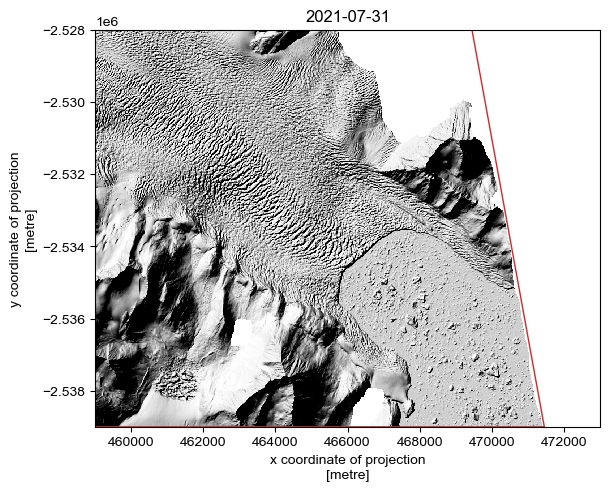

In [4]:
# =================
# SCENE TO PREVIEW
i = 5
# =================

preview = pdt.load.preview(gdf.iloc[[i]], bounds)

fig, ax = plt.subplots(layout='constrained')
preview.plot.imshow(cmap='Greys_r', add_colorbar=False)

gdf.iloc[[i]].plot(ax=ax, fc='none', ec='tab:red')

ax.set_title(gdf.iloc[[i]].pdt_datetime1.dt.date.values[0])
plt.show()

By examining the individual strips one-by-one, we can manually identify the optimal scenes for our purpose. 

> ⚠️
> **NOTE**: The `preview()` option draws on PGC-provided data, which is automatically masked according to the PGC bitmask. It is entirely possible that the `search()` function can return a valid datastrip that covers a sufficient proportion of the AOI to meet the `min_aoi_frac` requirements, but it will appear empty (i.e. all-`NaN`) when viewed. The `preview()` function will help you identify these 'empty' scenes, but there may still be (poor-quality) data present if it is downloaded using the `load.from_search()` function with `bitmask=False`. However, by default, `load.from_search()`defaults to `bitmask = True`.

Here, I have selected the second and sixth strips (index positions 1 and 5)

In [5]:
selected_scenes = [1, 5]

Let's save the selected scenes as a geopackage, so we can return to this later:

In [6]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

In [7]:
gdf_sel = gdf.iloc[selected_scenes]

gdf_sel.to_file(os.path.join('example_data', 'scenes.gpkg'))

gdf_sel

,geometry,gsd,title,created,license,rmse,proj:code,published,is_lsf,proj:shape,...,href_hillshade,href_hillshade_masked,pdt_id,pdt_datetime1,pdt_datetime2,pdt_dem_baseline_hours,pdt_datetime_mean,pdt_year,pdt_month,pdt_aoi_frac
1,"POLYGON Z ((459000 -2539000 0, 459000 -2528000...",2.0,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,2021-11-07T04:24:10Z,CC-BY-4.0,-9999,EPSG:3413,2022-09-22T05:38:17Z,True,"[11287, 12320]",...,https://pgc-opendata-dems.s3.us-west-2.amazona...,https://pgc-opendata-dems.s3.us-west-2.amazona...,SETSM_s2s041_WV01_20170624_1020010060B7D000_10...,2017-06-24 16:35:53+00:00,2017-06-24 16:36:43+00:00,0.0,2017-06-24 16:36:18+00:00,2017,6,1.000000
5,"POLYGON Z ((471450.48 -2539000 0, 459000 -2539...",2.0,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,2021-11-07T04:32:49Z,CC-BY-4.0,-9999,EPSG:3413,2022-09-22T05:38:21Z,True,"[48497, 17156]",...,https://pgc-opendata-dems.s3.us-west-2.amazona...,https://pgc-opendata-dems.s3.us-west-2.amazona...,SETSM_s2s041_WV02_20210731_10300100C359CF00_10...,2021-07-31 14:09:25+00:00,2021-07-31 14:10:48+00:00,0.0,2021-07-31 14:10:06.500000+00:00,2021,7,0.817726


## Downloading the strips

From the geopandas dataframe, we can extract key information such as the DEM ID and dates:

In [8]:
date_1 = gdf_sel.iloc[[0]].pdt_datetime1.dt.date.values[0]
dem_id_1 = gdf_sel.iloc[[0]].pdt_id.values[0]

date_2 = gdf_sel.iloc[[1]].pdt_datetime2.dt.date.values[0]
dem_id_2 = gdf_sel.iloc[[1]].pdt_id.values[0]

But we needn't do all this just to downlad a strip, as the `load.from_search()` function will accept a dataframe row directly. Let's make a little function to download and save the data - we can save the dem using the rioxarray accessor function `.rio.to_raster()`. 

In [9]:
def download_scene(gdf_row, dem_id, bounds=bounds, output_directory='example_data'):

    out_fpath = os.path.join(output_directory, f'{dem_id}.tif')

    if not os.path.exists(out_fpath):
        
        dem = pdt.load.from_search(gdf_row, bounds=bounds, bitmask=True)
                
        dem.rio.to_raster(out_fpath, compress='ZSTD', predictor=3, zlevel=1)
    
        return dem

    else:
        
        return pdt.load.from_fpath(out_fpath, bounds=bounds)

Note, these are 2 m strips that will take a while to download! To save on added time when rerunning this notebook, I've added an additional test to the function: if we've already downloaded the DEM and saved it to the local directory, this function will instead load it from the local file location using the `load.from_fpath()` function.

> ⚠️
> **NOTE**: More advanced geospatial python users may wish to note that DEMs can be loaded as `dask` arrays, enabling lazy evaluation and only triggering download when required by a further command. This is done providing a `chunks` parameter to `load.from_search()`, `load.from_id()`, or `load.mosaic()` (e.g.`(50, 50)`, `True`, `"auto"`), as is the case for [the `rioxarray.load_rasterio()` function that it wraps](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio).

Regardless, we can now use this function to select and download relevant rows from our geodataframe using the standard Pandax indexing method (`DataFrame.iloc[[i]]`, where `i` is the desired row index):

In [10]:
dem_1 = download_scene(gdf_sel.iloc[[0]], dem_id_1, bounds)

In [11]:
dem_2 = download_scene(gdf_sel.iloc[[1]], dem_id_2, bounds)

Let's plot up one of the DEMs, taking advantage of the in-built hillshade generation function:

In [12]:
hillshade_1 = dem_1.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=2)
hillshade_2 = dem_2.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=2)

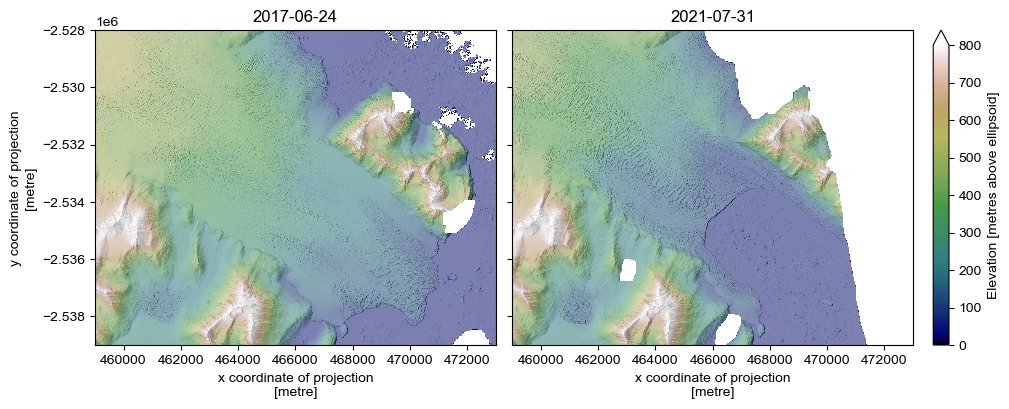

In [13]:
fig, axes = plt.subplots(layout='constrained', ncols=2, figsize=(10,3.9), sharex=True, sharey=True)

ax = axes[0]
dem_1.plot.imshow(cmap='gist_earth', vmin=0, vmax=800, ax=ax, add_colorbar=False) # cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
hillshade_1.plot.imshow(cmap='Greys_r', alpha=.5, ax=ax, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title(date_1)

ax = axes[1]
dem_2.plot.imshow(cmap='gist_earth', vmin=0, vmax=800, ax=ax, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
hillshade_2.plot.imshow(cmap='Greys_r', alpha=.5, ax=ax, add_colorbar=False)
ax.set_ylabel(None)
ax.set_aspect('equal')
ax.set_title(date_2)

plt.show()

## Change through time

As the surface height changes between these two images is particularly large (on the order of 100 m), we can get a first-order approximation of surface change by subtracting the latter image from the first:

In [14]:
dz = (dem_2 - dem_1)

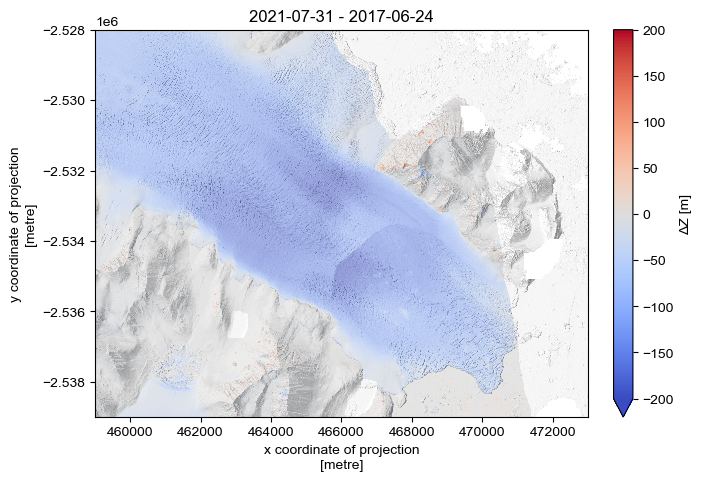

In [15]:
fig, ax = plt.subplots(layout='constrained', figsize=(7,4.7))

vrange = 200
dz.plot.imshow(cmap='coolwarm', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'ΔZ [m]'})
hillshade_1.plot.imshow(cmap='Greys_r', alpha=.5, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(f'{date_2} - {date_1}')

plt.show()

You might notice some odd patches of colour in the off-ice region. This is because rigorous DEM differencing necessitates coregistering scenes. pDEMtools provides functions to faciliate a common iterative method of coregistration, which we explore in the 'Coregistration' tutorial.